# Contents
1. [Data Cleansing](#data_clean)  
    1.1 [Dealing with missing values](#nan_values)  
    1.2 [Searching for duplicates](#doubles)   
2. [Exploratory Data Analysis](#eda)  
    2.1 [Numeric features analysis](#num_eda)  
    2.2 [Categorical features analysis](#cat_eda)
3. [Logistic Regression](#logreg)  
4. [Random Forest](#rnd)
5. [Gradient Boosting Methods](#gbm)  
    5.1 [XGBoost](#xgb)  
    5.2 [Catboost](#catb)

In [1]:
#If necessary
#!pip install catboost
#!pip install xgboost

     |████████████████████████████████| 66.2MB 57kB/s 


In [2]:
# I used some deprecated functions (seaborn), so you can turn warnings off
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

In [3]:
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sts
import xgboost as xgb
import catboost as catb

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import pipeline, preprocessing, compose, model_selection, linear_model, metrics

## 1. Data Cleansing <a name = "data_clean"></a>

In [4]:
data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
print(f'Train dataset contains information about {len(data)} customers with {len(data.columns) - 1} features')
data.head()

Train dataset contains information about 5282 customers with 19 features


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


### 1.1 Dealing with missing values <a name = "nan_values"></a>

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

The dataset seems to have no missing values, but it's just a trick of teachers. We see many columns have **object** data type, i.e., these columns store values with mixed types. But how `TotalSpent` column can contain any values besides **int** or **float**?  
Thankfully, we can easily interpret each feature and make some suggestions:
1. Columns `ClientPeriod` and `MonthlySpending` must store integer or real values, what corresponds with their data types;  
2. Column `TotalSpent` is supposed to be similar to columns above, but its data type is **object**. Hmm, very strange...  
3. Columns `IsSeniorCitizen` and `Churn` have **int** data type. These features, by their nature, are binary. So we just need to check if they store any values besides 0 and 1;  
4. Other features are likely to be categorical, so we should take a hard look at each of them.

Let's start with `TotalSpent` and check if this column stores any values besides string ones.

In [6]:
for df in (data, test_data):
    print(list(itertools.filterfalse(lambda x: isinstance(x, str), df['TotalSpent'])))

[]
[]


Hence, column `TotalSpent` stores only string values. As we see above, its values, actually, are numeric converted to strings. So let's try convert all values to numeric and print values that can't be converted.

In [7]:
data.loc[pd.to_numeric(data['TotalSpent'], errors='coerce').isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [8]:
test_data.loc[pd.to_numeric(test_data['TotalSpent'], errors='coerce').isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


That's good, we have few rows with empty cell in `TotalSpent` column: 9 in train dataset and 2 in test dataset. You might want to delete these rows, because this group is less than 0.1 % of whole dataset, but be careful.  
`ClientPeriod` for each object in this group is zero. Is it just a coincidence?

In [9]:
data.loc[(data['ClientPeriod'] == 0) | (data['TotalSpent'] == '')]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [10]:
test_data.loc[(test_data['ClientPeriod'] == 0) | (test_data['TotalSpent'] == '')]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


No, it's the same group. What's next? Delete or replace values and how?  
Deleting may lead to the loss of valuable information – we will erase the whole group of customers, moreover, we can't just delete rows from the test set. Reckless replacing may lead to the appearance of outliers and data distortion.  
Common sense tells us that these objects may be customers who just have signed contract very recently, less than a month ago. That's why their `Churn` label is zero too.  
Then it seems logical to replace these empty cells to zeros.
_____
*Note for future experiments:*  
It's really simple solution, but there is no guarantee that it's the best one. In the future we can try other replacing methods, for example, KNN-algorithm.

In [11]:
for df in (data, test_data):
    df['TotalSpent'] = pd.to_numeric(df['TotalSpent'], errors='coerce')
    df.loc[df['ClientPeriod'] == 0, 'TotalSpent'] = 0

In [12]:
print('Feature – its categories:\n')
for feat in data.columns.tolist()[3:]:
    print(f'{feat} – {data[feat].unique()}')

Feature – its categories:

Sex – ['Male' 'Female']
IsSeniorCitizen – [0 1]
HasPartner – ['Yes' 'No']
HasChild – ['Yes' 'No']
HasPhoneService – ['Yes' 'No']
HasMultiplePhoneNumbers – ['No' 'Yes' 'No phone service']
HasInternetService – ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService – ['No internet service' 'No' 'Yes']
HasOnlineBackup – ['No internet service' 'No' 'Yes']
HasDeviceProtection – ['No internet service' 'No' 'Yes']
HasTechSupportAccess – ['No internet service' 'Yes' 'No']
HasOnlineTV – ['No internet service' 'No' 'Yes']
HasMovieSubscription – ['No internet service' 'No' 'Yes']
HasContractPhone – ['One year' 'Two year' 'Month-to-month']
IsBillingPaperless – ['No' 'Yes']
PaymentMethod – ['Mailed check' 'Credit card (automatic)' 'Electronic check'
 'Bank transfer (automatic)']
Churn – [0 1]


Everything looks all right.
The cardinality of features: `Sex`, `HasPartner`, `HasChild`, `HasPhoneService`, `IsBillingPaperless` – is 2, so we can transform them to binary ones like `IsSeniorCitizen` feature.

In [13]:
bin_feats = ['Sex', 'HasPartner', 'HasChild', 'HasPhoneService', 'IsBillingPaperless']
bin_dict = {'Male': 0, 'Female' : 1, 'No': 0, 'Yes': 1}
for df in (data, test_data):
    df.loc[:, bin_feats] = df.loc[:, bin_feats].replace(bin_dict)
bin_feats.append('IsSeniorCitizen')
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,0,0,1,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,0,Mailed check,0
1,72,25.85,1872.20,0,0,1,0,1,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Credit card (automatic),0
2,1,75.90,75.90,0,0,0,0,1,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,1,Electronic check,1
3,32,79.30,2570.00,1,1,1,0,1,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,0,Mailed check,0
4,60,115.25,6758.45,1,0,1,1,1,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,0,Credit card (automatic),0


In [14]:
num_feats = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
cat_feats = data.select_dtypes(exclude='number').columns.tolist()

all_feats = num_feats + bin_feats + cat_feats
target = ['Churn']

print(sorted(all_feats + target) == sorted(data.columns.tolist()))

True


### 1.2 Searching for duplicates <a name = "doubles"></a>

In [15]:
print(f'The number of all duplicates is {data.duplicated(keep=False).sum()} with {data.duplicated().sum()} unique ones'  )
data[data.duplicated()]

The number of all duplicates is 28 with 14 unique ones


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1384,1,69.90,69.90,0,0,0,0,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,1
1474,1,20.05,20.05,0,0,0,0,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Mailed check,0
1636,1,19.65,19.65,1,0,0,0,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Mailed check,0
1959,1,45.70,45.70,0,0,0,0,1,No,DSL,No,No,No,No,No,No,Month-to-month,1,Mailed check,1
2036,1,69.35,69.35,0,0,0,0,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,1
2586,1,20.20,20.20,0,0,0,0,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,1,Mailed check,1
2877,1,70.10,70.10,1,0,0,0,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,1
2991,1,20.90,20.90,1,0,0,0,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Mailed check,1
3660,1,20.45,20.45,0,0,0,0,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Mailed check,0
3749,1,20.20,20.20,0,0,0,0,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Mailed check,0


All these customers have signed the contract a month ago and haven't spent too much. Also, we don't know their real ID's. So, we can't be absolutely sure whether they are duplicates or not.  
Let's take a little risk and delete these rows.
_____
*Note for future experiments:*  
In the future, we can return to this issue and make rough probability estimation of the occurence of duplicated records. 

In [16]:
data.drop_duplicates(inplace = True)
data.reset_index(inplace = True, drop = True)

## 2. Exploratory data analysis <a name = "eda"></a>

In [17]:
data['Churn'].value_counts(normalize = True)

0    0.73918
1    0.26082
Name: Churn, dtype: float64

The churn rate is 0.26, so we can consider train dataset as slightly imbalanced. However, this imbalance rate is quite convenient for us, especially in comparison to some other datasets. 

### 2.2 Numeric features analysis <a name = "num_eda"></a>
Let's start with the obvious – correlation.

In [18]:
data[num_feats].corr()

,ClientPeriod,MonthlySpending,TotalSpent
ClientPeriod,1.000000,0.248047,0.826167
MonthlySpending,0.248047,1.000000,0.651984
TotalSpent,0.826167,0.651984,1.000000


There's nothing strange about strong positive correlation between features `ClientPeriod` and `TotalSpent`. Fortunately, this relationship isn't perfect direct lineal.

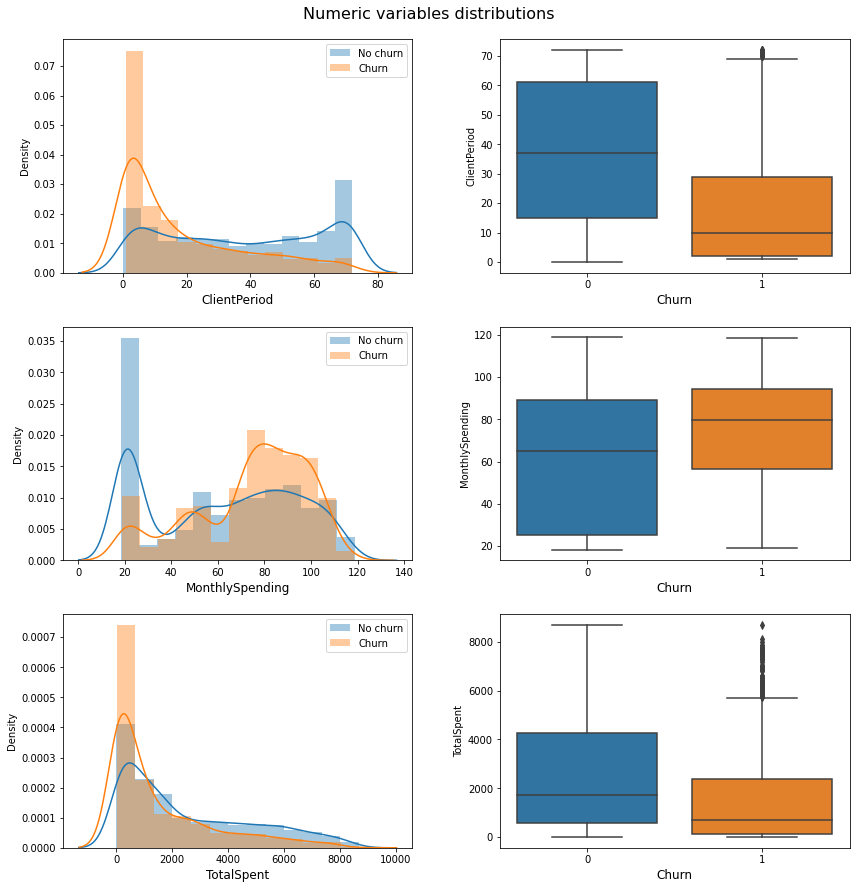

In [19]:
fig, axes = plt.subplots(nrows=len(num_feats), ncols=2, figsize=(12, 4 * len(num_feats)))
n_bins = 1 + int(np.floor(np.log2(len(data)))) # A variant of Sturges' rule 

for i, feat in enumerate(num_feats):
    ax1 = axes[i][0]
    ax2 = axes[i][1]
    sns.distplot(data[data['Churn'] == 0][feat], bins=n_bins, ax=ax1, label='No churn')
    sns.distplot(data[data['Churn'] == 1][feat], bins=n_bins, ax=ax1, label='Churn')
    sns.boxplot(x='Churn', y=feat, data=data, ax=ax2)
    ax1.legend()
    ax1.set_xlabel(feat, fontsize=12)
    ax2.set_xlabel('Churn', fontsize=12)
fig.suptitle('Numeric variables distributions', y=1.025, fontsize=16)    
fig.tight_layout(h_pad=2, w_pad=4)

The distribution of `TotalSpent` has a long "tail" of values, but overall, distributions look good.   
Let's check if numeric variables in test dataset have similar distributions.
_____
*Notes for future experiments:*  
1. `TotalSpent` values lying outside the "whiskers" may affect some models negatively. To deal with the outliers we can try to transform values using nonlinear function like as square root.  
2. The latest seaborn update has completely overhauled distribution module. For instance, distplot() is now deprecated, and I have to adapt my code in nearest future.

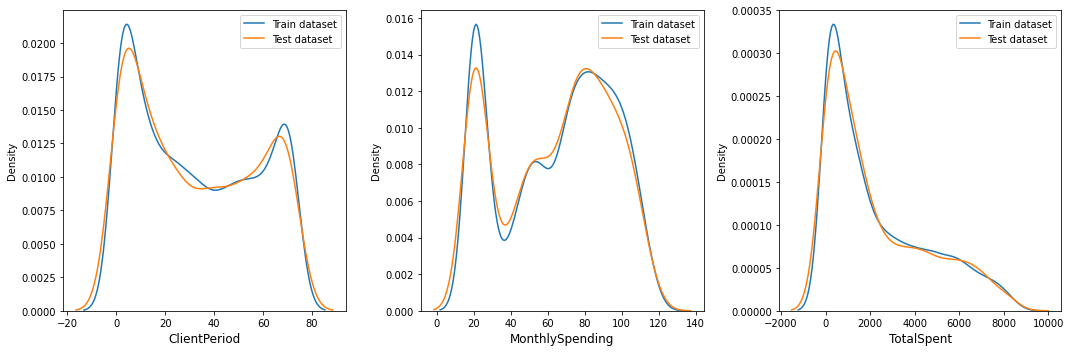

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, feat in enumerate(num_feats):
    ax = axes.ravel()[i]
    sns.distplot(data[feat], hist=False, ax=ax, label='Train dataset')
    sns.distplot(test_data[feat], hist=False, ax=ax, label='Test dataset')
    ax.legend()
    ax.set_xlabel(feat, fontsize = 12)
fig.tight_layout()

Distributions are almost identical.

### 2.2 Categorical features analysis <a name = "cat_eda"></a>
Let's take a look at categorical features and draw barplots for them. Since `Churn` variable takes values 0 and 1, the height of bar will represent not only `Churn` mean value for each of categories, but also actual churn rate. Furthermore, seaborn barplots automatically draw confidence intervals around estimated mean value. It will help us not to overestimate mean values for small groups.  
Additionally, let's print churn rate and total number of customers over every bar.

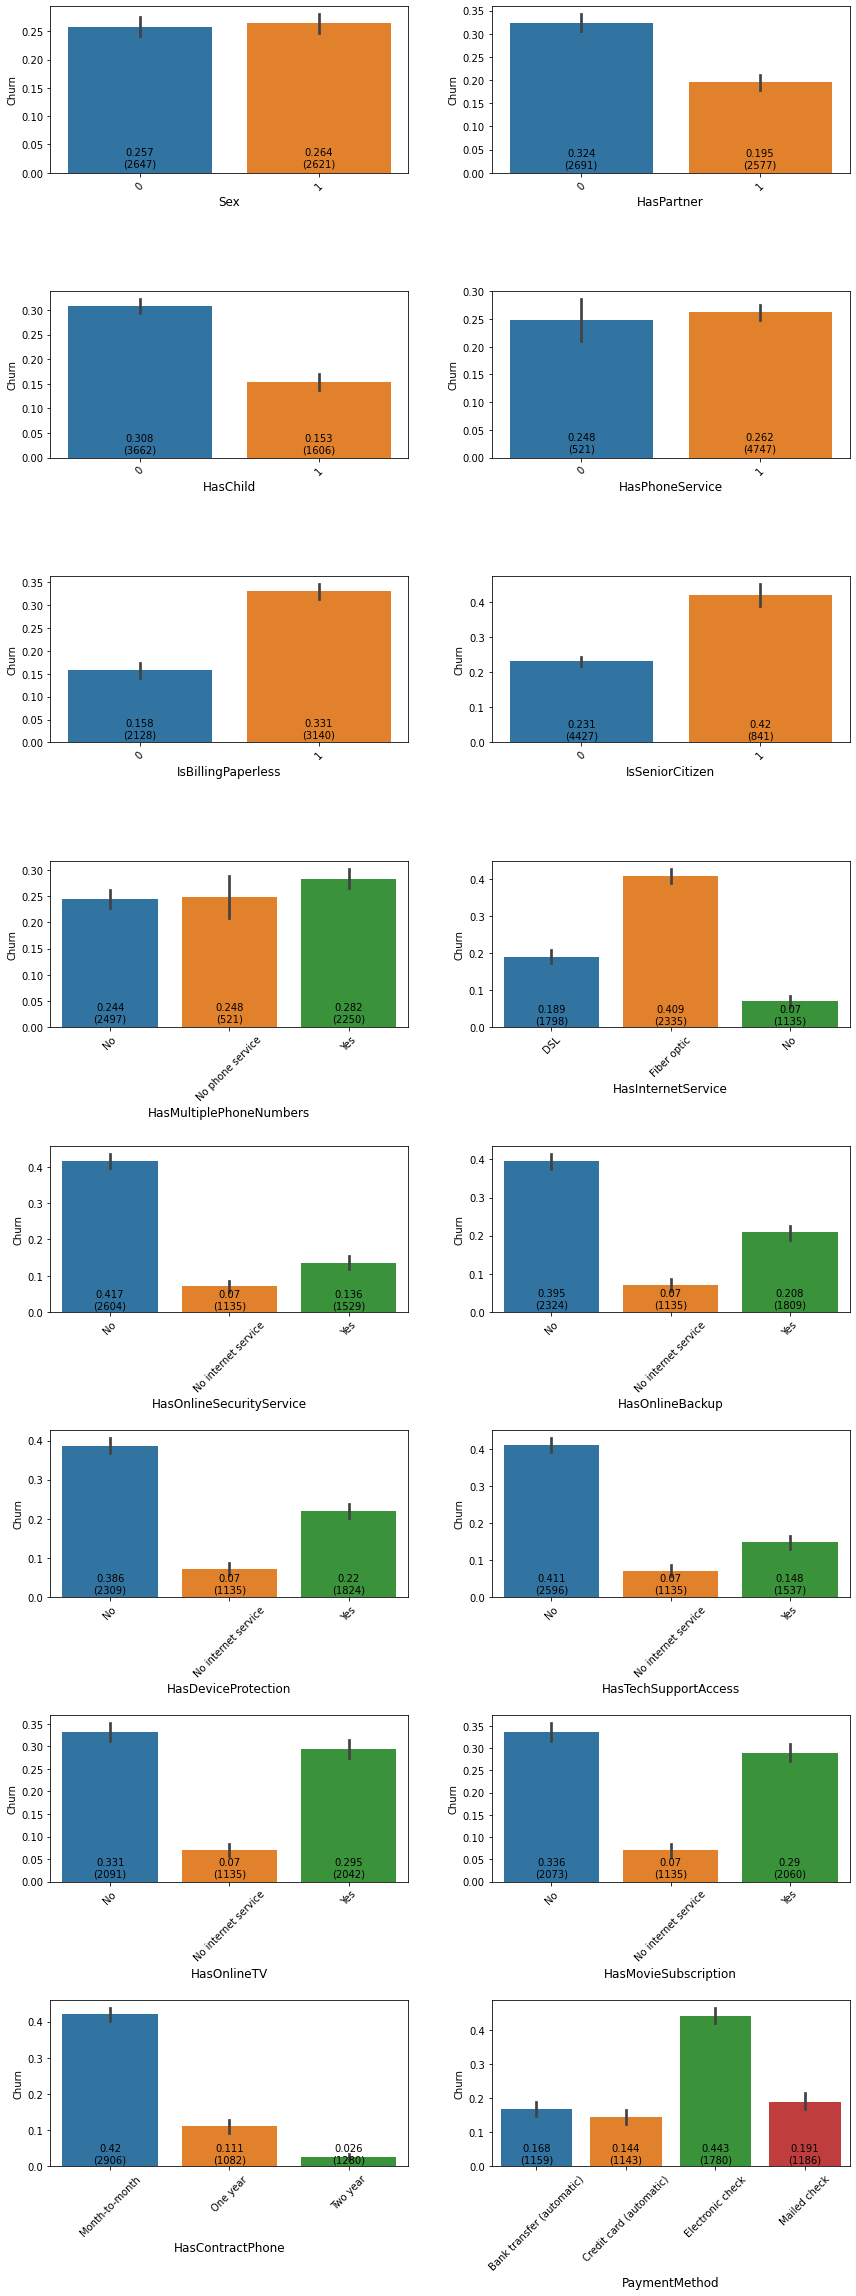

In [21]:
discr_feats = bin_feats + cat_feats
fig, axes = plt.subplots(nrows=int(len(discr_feats) / 2), ncols=2, figsize=(12, 2 * len(discr_feats)))

for i, feat in enumerate(discr_feats):
    ax = axes.ravel()[i]
    sns.barplot(data[feat], data['Churn'], ax=ax, order=sorted(data[feat].unique()))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel(feat, fontsize=12)
    for j, cat in enumerate(sorted(data[feat].unique())):
        churn = [round(data[data[feat] == cat]['Churn'].mean(), 3), data[data[feat] == cat]['Churn'].count()]
        ax.text(x=j, y=0.01, s=f'{churn[0]}\n({churn[1]})', horizontalalignment='center')
fig.tight_layout(h_pad=2, w_pad=4)

In general, all features are good in the sense that every category has enough objects.  
It's obvious that some features like `Sex` or `HasPhoneService` have the slightest influence on churn rate. On the other hand, features like `HasContractPhone`, `HasInternetService` or `PaymentMethod` may be very useful for predictions, because these features have churn rate varying from category to category.  
It's interesting to estimate the power of dependence between churn and different features, but first we need to check test dataset. We can do it this way: get array with frequency distribution for every feature using ***.value_counts()***, calculate difference between train and test datasets and print a warning if difference for any category is above 5%.

In [22]:
susp_feats = []
for feat in discr_feats:
    diff = np.array(data[feat].value_counts(normalize=True)) - np.array(test_data[feat].value_counts(normalize=True))
    if (abs(diff) > 0.05).sum():
        print(f'Feature {feat} looks suspicious')
        susp_feats.append(feat)
if len(susp_feats) == 0:
    print('There is no serious difference in categorical variables distribution between datasets')

There is no serious difference in categorical variables distribution between datasets


Now, we estimate correlation between churn and every categorical feature using contingency tables and Cramer's V coefficient. In the case of binary features it is equal to Pearson's phi coefficient (in fact, Matthews correlation coefficient).
The basic idea is as follows: 

1. Let's test the null hypothesis $H_0$, which states that categorical features $X_1$ and $X_2$ are independent. 
2. The statement that the null hypothesis $H_0$ is wrong – is the alternative hypothesis $H_1$. 
3. Create contingency table of features and calculate the chi-square statistic.
4. Under the null hypothesis the statistic has to follow chi-square distribution: 

$$\chi^2 (X_1^n, X_2^n) \sim \chi^2_{(K_1-1)(K_2-1)}$$
$K_1$, $K_2$ – number of rows and columns 

Besides, we should follow several requirements:
1. Size of the sample should be above 40;
2. No more than 20% of the cells have expected frequencies below 5  $^1$    


$$\frac{n_{i+}n_{j+}}{n} < 5 $$   


It's obvious that the first requirement is not a problem, but the second one should be controlled.  
Cramer's V is computed using the following formula:  

$$\phi_c(X^n_1, X^n_2) = \sqrt{\frac{\chi^2 (X_1^n, X_2^n)}{n(min(K_1, K_2)-1)}}$$ 

*************
$^1)$  In the case of 2x2 contingency tables the requirement applies to every cell.

In [23]:
corr_churn = {}
for feat in discr_feats:
    crosstab = pd.crosstab(data[feat], data['Churn'])
    expected_crosstab = sts.chi2_contingency(crosstab)[3]
    if crosstab.shape == (2, 2):
        if (expected_crosstab < 5).any():
            print(f'Houston, we have a problem with feature {feat}, which takes {data[feat].nunique()} unique values')
            continue
    else:
        if (expected_crosstab < 5).sum() > (crosstab.size / 5):
            print(f'Houston, we have a problem with feature {feat}, which takes {data[feat].nunique()} unique values')
            continue
    corr_churn[feat] = [sts.chi2_contingency(crosstab)[1], 
                               np.sqrt(sts.chi2_contingency(crosstab)[0]/len(data)), data[feat].nunique()]

In [24]:
corr_churn = pd.DataFrame.from_dict(corr_churn, orient='index', columns=['p-value', 'V Kramer', 'n_unique'])
corr_churn

,p-value,V Kramer,n_unique
Sex,5.768736e-01,0.007687,2
HasPartner,3.483619e-26,0.145842,2
HasChild,7.091785e-32,0.161883,2
HasPhoneService,5.019845e-01,0.009250,2
IsBillingPaperless,2.239194e-44,0.192533,2
IsSeniorCitizen,3.863437e-30,0.157161,2
HasMultiplePhoneNumbers,9.299536e-03,0.042142,3
HasInternetService,7.273794e-115,0.315875,3
HasOnlineSecurityService,1.926033e-145,0.355678,3
HasOnlineBackup,1.808861e-99,0.293800,3


Additionally, we use simple Bonferroni correction to counteract the problem of multiple comparisons.

In [25]:
corr_churn['p-value'] = corr_churn['p-value'].apply(lambda x: x * len(corr_churn))
corr_churn['p-value < 0.05'] = corr_churn['p-value'].apply(lambda x: 'Yes' if x < 0.05 else 'No')
corr_churn

,p-value,V Kramer,n_unique,p-value < 0.05
Sex,9.229978e+00,0.007687,2,No
HasPartner,5.573790e-25,0.145842,2,Yes
HasChild,1.134686e-30,0.161883,2,Yes
HasPhoneService,8.031751e+00,0.009250,2,No
IsBillingPaperless,3.582710e-43,0.192533,2,Yes
IsSeniorCitizen,6.181499e-29,0.157161,2,Yes
HasMultiplePhoneNumbers,1.487926e-01,0.042142,3,No
HasInternetService,1.163807e-113,0.315875,3,Yes
HasOnlineSecurityService,3.081652e-144,0.355678,3,Yes
HasOnlineBackup,2.894178e-98,0.293800,3,Yes


Computations prove our conclusions of barplots above. We see three features which have weak relation with churn – `Sex`, `HasPhoneService` and `HasMultiplePhoneNumbers`.
Other features seem to be more useful. For example, relation between `HasContractPhone` feature and churn can be described as relatively high.     
Now let's estimate the power of relationship between features in the same way.

In [26]:
corr_feats = {}
for i in itertools.combinations(discr_feats, 2):
    feat_1, feat_2 = i[0], i[1]
    crosstab = pd.crosstab(data[feat_1], data[feat_2])
    expected_crosstab = sts.chi2_contingency(crosstab)[3]
    if crosstab.shape == (2, 2):
        if (expected_crosstab < 5).any():
            print(f'Houston, we have a problem with features {feat_1} and {feat_2}, which take \
            {data[feat_1].nunique()} and {data[feat_2].nunique()} unique values')
            continue
    else:
        if (expected_crosstab < 5).sum() > (crosstab.size / 5):
            print(f'Houston, we have a problem with features {feat_1} and {feat_2}, which take \
            {data[feat_1].nunique()} and {data[feat_2].nunique()} unique values')
            continue
    corr_feats[i] = np.sqrt(sts.chi2_contingency(crosstab)[0] / (len(data) * (min(crosstab.shape) - 1)))

In [27]:
sorted_corr_feats = sorted(corr_feats.items(), key = lambda x: abs(x[1]), reverse = True)
sorted_corr_feats[:10]

[(('HasPhoneService', 'HasMultiplePhoneNumbers'), 1.0),
 (('HasOnlineTV', 'HasMovieSubscription'), 0.774921899034679),
 (('HasDeviceProtection', 'HasMovieSubscription'), 0.7368766619725051),
 (('HasDeviceProtection', 'HasOnlineTV'), 0.7340283256273878),
 (('HasOnlineSecurityService', 'HasTechSupportAccess'), 0.7318582215136185),
 (('HasDeviceProtection', 'HasTechSupportAccess'), 0.7264667346718243),
 (('HasInternetService', 'HasOnlineSecurityService'), 0.7251399358190986),
 (('HasInternetService', 'HasTechSupportAccess'), 0.7242455132556386),
 (('HasOnlineBackup', 'HasDeviceProtection'), 0.7191420606416546),
 (('HasOnlineBackup', 'HasTechSupportAccess'), 0.7189669252773574)]

Bingo! One of `HasPhoneService` and `HasMultiplePhoneNumbers` features is completely determined by another one. Indeed, we can see even on barplots that `HasMultiplePhoneNumbers` categories cover `HasPhoneService` categories perfectly. Let's delete this feature because it doesn't contain any additional valuable information.

In [28]:
for feat_list in (bin_feats, discr_feats, all_feats):
    feat_list.remove('HasPhoneService')

## 3. Logistic Regression <a name = "logreg"></a>
Our training dataset is relatively small, that's why we use simple cross-validation scheme without holdout-dataset. Of course, we build a little pipeline with transformers and classifier to avoid data leakages. 
_____
*Notes for future experiments:*  
1. I'm pretty interested in other validation schemes. In this subject, articles by Sebastian Raschka may be valuable source of information for me. Also, it's interesting to estimate the optimal number of folds.  
2. Initial preprocessing transformers in this pipeline are very simple. It may be sense to try various ones, for example, encoders from category_encoders module.

In [29]:
train_labels = data['Churn'].to_numpy()
train_data = data.drop('Churn', axis=1)

cv_split = model_selection.StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1', 'average_precision']
clf_results = pd.DataFrame()

num_transformer = pipeline.Pipeline(steps = [('scaler', preprocessing.MinMaxScaler())])
cat_transformer = pipeline.Pipeline(steps = [('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'))])

preprocessor = compose.ColumnTransformer(transformers = [('num', num_transformer, num_feats + bin_feats), 
                                                        ('cat', cat_transformer, cat_feats)],
                                         remainder='drop')

In [30]:
def cross_val_results(name, estimator):
    results = model_selection.cross_validate(estimator, train_data, train_labels, 
                                             scoring=scoring, cv=cv_split, n_jobs=-1)
    print('Metrics on all folds:')
    for metric in list(results.keys())[2:]:
        clf_results.loc[name, metric] = np.mean(results[metric])
        print(f'{metric}: {results[metric]}')

In [31]:
log_clf = linear_model.LogisticRegression(solver='lbfgs', class_weight='balanced', 
                                          max_iter=1000, random_state=42, n_jobs=-1)
log_estimator = pipeline.Pipeline(steps = [('preprocessor', preprocessor), ('classifier', log_clf)])
cross_val_results('log_bsln', log_estimator)
clf_results

Metrics on all folds:
test_roc_auc: [0.86013613 0.81951886 0.85275849 0.84211202]
test_accuracy: [0.75778284 0.73044799 0.74411541 0.7365224 ]
test_precision: [0.52264151 0.4887218  0.50604491 0.49731664]
test_recall: [0.80758017 0.75801749 0.85174419 0.80813953]
test_f1: [0.63459336 0.59428571 0.63488624 0.61572536]
test_average_precision: [0.6783399  0.61064909 0.64571061 0.65879593]


,test_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_average_precision
log_bsln,0.843631,0.742217,0.503681,0.80637,0.619873,0.648374


Let's start with **C** hyperparameter tuning.

In [32]:
def plot_validation_curves(model, **hyperparams):
    n_rows = (len(hyperparams) - 1) // 2 + 1
    n_cols = (int(len(hyperparams) > 1) + 1)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4 * n_rows), squeeze=False)
    i = 0
    for param, param_range in hyperparams.items():
        train_scores, test_scores = model_selection.validation_curve(model,
                        train_data, train_labels, param_name=param, param_range=param_range,
                        cv=cv_split, scoring='roc_auc', n_jobs=-1)
        ax = axes.ravel()[i]
        ax.plot(param_range, train_scores.mean(axis=1), 'g-', marker='o', label='train_score')
        ax.plot(param_range, test_scores.mean(axis=1), 'r-', marker='o', label='val_score')
        ax.legend()
        ax.grid()
        ax.set_xlabel(param, fontsize=12)
        ax.set_ylabel('AUC-ROC score', fontsize=12)
        print(f'{param}:\ntrain scores: {train_scores.mean(axis=1)}\ntest scores: {test_scores.mean(axis=1)}\n')
        i += 1 
    fig.tight_layout(h_pad=2, w_pad=4)

classifier__C:
train scores: [0.82963925 0.83217184 0.83462907 0.83691478 0.8390361  0.84094631
 0.84256255 0.84383331 0.84475976 0.84545694 0.84595435 0.84643431
 0.84689328 0.84734625 0.84772523 0.84803882 0.84827699 0.84845576
 0.84860845 0.84872459 0.84879754 0.84883816 0.84887472 0.8489121
 0.84893005]
test scores: [0.82784235 0.83006017 0.83220823 0.83421508 0.83619727 0.83793215
 0.83922672 0.84033056 0.84117879 0.84174159 0.84210555 0.84251139
 0.84283285 0.84326423 0.8435282  0.84377945 0.84395827 0.84411756
 0.84420887 0.84427102 0.84427187 0.84426594 0.84423912 0.84423616
 0.84420408]



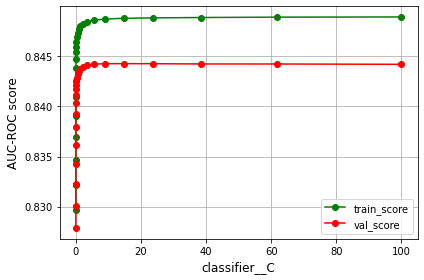

In [33]:
plot_validation_curves(log_estimator, classifier__C=np.logspace(-3, 2, 25))

С ~ 10 seems to be optimal value for our model. Now let's go to gridsearch and, just for sport, let's try to search over C values, optimization solvers and penalty types.

In [34]:
%%time
log_parameters_grid = [
    {'classifier__penalty': ['l1'], 'classifier__solver': ['liblinear', 'saga'], 'classifier__C': np.arange(1, 16, 3)},
    {'classifier__penalty': ['l2'], 'classifier__solver': ['newton-cg', 'sag', 'saga', 'lbfgs', 'liblinear'], 
     'classifier__C': np.arange(1, 16, 3)},
    {'classifier__penalty': ['elasticnet'], 'classifier__solver': ['saga'], 'classifier__C': np.arange(1, 16, 3)}
]

log_grid_cv = model_selection.GridSearchCV(log_estimator, log_parameters_grid, scoring='roc_auc', cv=cv_split, n_jobs=-1)
log_grid_cv.fit(train_data, train_labels)
log_estimator = log_grid_cv.best_estimator_

print(f'Best score is {log_grid_cv.best_score_} with the following parameters:\n{log_grid_cv.best_params_}')

Best score is 0.8442823238241057 with the following parameters:
{'classifier__C': 13, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
CPU times: user 1.6 s, sys: 65.3 ms, total: 1.66 s
Wall time: 43.1 s


In [35]:
cross_val_results('log_bsln + grid_search', log_estimator)
clf_results

Metrics on all folds:
test_roc_auc: [0.86095031 0.82111428 0.85187714 0.84318758]
test_accuracy: [0.75702354 0.73044799 0.74259681 0.7357631 ]
test_precision: [0.52141527 0.48867925 0.50430293 0.49641577]
test_recall: [0.81632653 0.75510204 0.85174419 0.80523256]
test_f1: [0.63636364 0.59335624 0.63351351 0.61419069]
test_average_precision: [0.682458   0.61494535 0.64415171 0.65697365]


,test_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_average_precision
log_bsln,0.843631,0.742217,0.503681,0.806370,0.619873,0.648374
log_bsln + grid_search,0.844282,0.741458,0.502703,0.807101,0.619356,0.649632


In [36]:
def final_score(name, estimator):
    estimator.fit(train_data, train_labels)
    submission = pd.read_csv('./submission.csv')
    submission['Churn'] = estimator.predict_proba(test_data)[:, 1]
    submission.to_csv(name + '_answers.csv', index=False)

In [37]:
final_score('log', log_estimator)

Logistic regression predictions on kaggle-test: $AUC - ROC = 0.84597$, pretty close to our results.

## 4. Random Forest <a name = "rnd"></a>

In [38]:
rnd_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', 
                                 max_depth=10, random_state=42, n_jobs=-1)
rnd_estimator = pipeline.Pipeline(steps = [('preprocessor', preprocessor), ('classifier', rnd_clf)])
cross_val_results('rnd_bsln', rnd_estimator)
clf_results

Metrics on all folds:
test_roc_auc: [0.84797445 0.82100502 0.85668425 0.83356288]
test_accuracy: [0.78359909 0.76309795 0.79422931 0.78359909]
test_precision: [0.57142857 0.5368171  0.58165548 0.57074341]
test_recall: [0.67638484 0.65889213 0.75581395 0.69186047]
test_f1: [0.61949266 0.59162304 0.6573957  0.62549277]
test_average_precision: [0.64676645 0.60593321 0.67674738 0.64670954]


,test_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_average_precision
log_bsln,0.843631,0.742217,0.503681,0.806370,0.619873,0.648374
log_bsln + grid_search,0.844282,0.741458,0.502703,0.807101,0.619356,0.649632
rnd_bsln,0.839807,0.781131,0.565161,0.695738,0.623501,0.644039


The score is a little discouraging, but perhaps, we've chosen bad initial parameters.

classifier__n_estimators:
train scores: [0.94883759 0.9519956  0.9532148  0.95387837 0.9542846  0.95441677
 0.95430824 0.95497843 0.95548302 0.95518774]
test scores: [0.8289252  0.83229038 0.83637199 0.83734271 0.83745627 0.83784969
 0.83840722 0.83893305 0.8395217  0.83980665]

classifier__max_depth:
train scores: [0.83610109 0.85096797 0.87444575 0.91277895 0.95518774 0.98298805
 0.99590981 0.99952528 0.99992782 0.99996627 0.99996843 0.99996669
 0.99996777 0.99996694 0.99996685 0.99996685 0.99996685 0.99996685
 0.99996685 0.99996685 0.99996685 0.99996685 0.99996685 0.99996685
 0.99996685]
test scores: [0.83130834 0.83955044 0.84322768 0.84345461 0.83980665 0.83522666
 0.83043601 0.82537349 0.81922672 0.81854443 0.81758    0.81872188
 0.81805202 0.81830872 0.81818249 0.81818249 0.81818249 0.81818249
 0.81818249 0.81818249 0.81818249 0.81818249 0.81818249 0.81818249
 0.81818249]

classifier__min_samples_leaf:
train scores: [0.94491033 0.92793718 0.91507451 0.90578768 0.89773939 0.89259

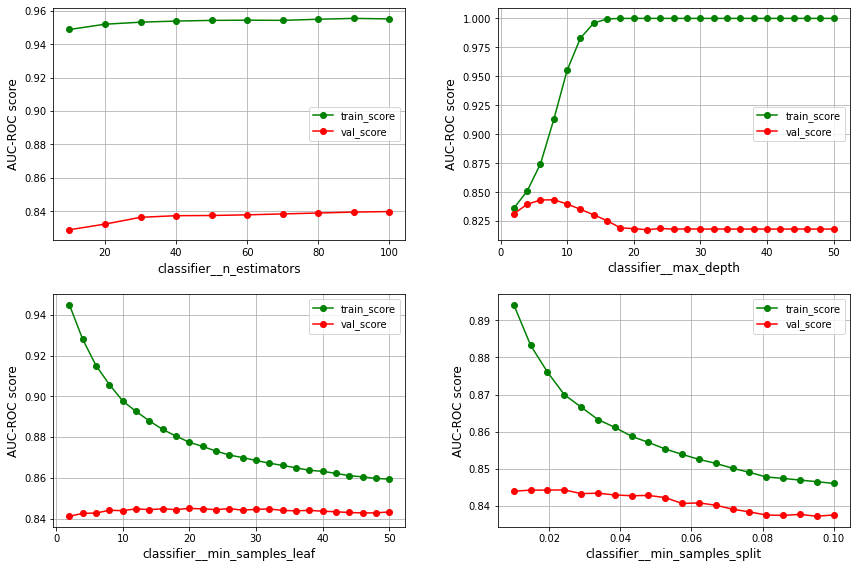

In [39]:
%%time
plot_validation_curves(rnd_estimator, 
                       classifier__n_estimators = np.linspace(10, 100, 10, dtype=int),
                       classifier__max_depth = np.linspace(2, 50, 25, dtype=int),
                       classifier__min_samples_leaf = np.linspace(2, 50, 25, dtype=int),
                       classifier__min_samples_split = np.linspace(0.01, 0.1, 20))

In [40]:
%%time
rnd_estimator.set_params(classifier__n_estimators = 100, classifier__max_depth = 4,
                        classifier__min_samples_leaf = 50, classifier__min_samples_split = 0.04)
rnd_parameters_grid = {
    'classifier__max_depth': np.arange(2, 9, 2, dtype=int),
    'classifier__n_estimators': np.arange(60, 141, 10, dtype=int),
    'classifier__min_samples_split': np.arange(0.01, 0.051, 0.01),
    'classifier__min_samples_leaf': np.arange(20, 61, 10)
}   

rnd_grid_cv = model_selection.GridSearchCV(rnd_estimator, rnd_parameters_grid, scoring='roc_auc', cv=cv_split, n_jobs=-1)
rnd_grid_cv.fit(train_data, train_labels)

print(f'Best score is {rnd_grid_cv.best_score_} with the following parameters:\n{rnd_grid_cv.best_params_}')

Best score is 0.8453980210852148 with the following parameters:
{'classifier__max_depth': 8, 'classifier__min_samples_leaf': 30, 'classifier__min_samples_split': 0.01, 'classifier__n_estimators': 80}
CPU times: user 41.6 s, sys: 1.59 s, total: 43.2 s
Wall time: 18min 32s


In [41]:
rnd_estimator.set_params(classifier__n_estimators = 80, classifier__max_depth = 8, 
                        classifier__min_samples_split = 0.01, classifier__min_samples_leaf = 30)
rnd_results = model_selection.cross_validate(rnd_estimator, train_data, train_labels, scoring=scoring, cv=cv_split)
cross_val_results('rnd_bsln + grid_search', rnd_estimator)
clf_results    

Metrics on all folds:
test_roc_auc: [0.8585497  0.82629115 0.85886971 0.83788152]
test_accuracy: [0.77220957 0.74107821 0.74867122 0.7365224 ]
test_precision: [0.54191033 0.502      0.51171171 0.49721707]
test_recall: [0.81049563 0.73177843 0.8255814  0.77906977]
test_f1: [0.64953271 0.59549229 0.63181313 0.60702152]
test_average_precision: [0.65619516 0.61424006 0.68397801 0.6577579 ]


,test_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_average_precision
log_bsln,0.843631,0.742217,0.503681,0.806370,0.619873,0.648374
log_bsln + grid_search,0.844282,0.741458,0.502703,0.807101,0.619356,0.649632
rnd_bsln,0.839807,0.781131,0.565161,0.695738,0.623501,0.644039
rnd_bsln + grid_search,0.845398,0.749620,0.513210,0.786731,0.620965,0.653043


In [42]:
final_score('rnd', rnd_estimator)

Random forest predictions on kaggle-test: $AUC - ROC = 0.84971$.

## 5. Gradient Boosting Methods <a name = "gbm"></a>

### 5.1 XGBoost <a name = "xgb"></a>


In [43]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=4, scale_pos_weight = 1 / train_labels.mean() - 1, 
                            learning_rate=0.05, random_state=42, n_jobs=-1)
xgb_estimator = pipeline.Pipeline(steps = [('preprocessor', preprocessor), ('classifier', xgb_clf)])
cross_val_results('xgb_bsln', xgb_estimator)
clf_results

Metrics on all folds:
test_roc_auc: [0.85220844 0.82274561 0.8609043  0.83147153]
test_accuracy: [0.75702354 0.7350038  0.75702354 0.7342445 ]
test_precision: [0.5223301  0.49431818 0.52105263 0.49440299]
test_recall: [0.78425656 0.76093294 0.86337209 0.77034884]
test_f1: [0.62703963 0.59931114 0.64989059 0.60227273]
test_average_precision: [0.65206715 0.61905086 0.68611205 0.65211478]


,test_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_average_precision
log_bsln,0.843631,0.742217,0.503681,0.806370,0.619873,0.648374
log_bsln + grid_search,0.844282,0.741458,0.502703,0.807101,0.619356,0.649632
rnd_bsln,0.839807,0.781131,0.565161,0.695738,0.623501,0.644039
rnd_bsln + grid_search,0.845398,0.749620,0.513210,0.786731,0.620965,0.653043
xgb_bsln,0.841832,0.745824,0.508026,0.794728,0.619629,0.652336


Not bad for initial parameters. Let's repeat the previous steps.

classifier__n_estimators:
train scores: [0.86275824 0.86428293 0.86679473 0.8693069  0.8714813  0.87356534
 0.87537478 0.87736513 0.87911967 0.88089946 0.88239414 0.88397603
 0.88557082 0.88689956 0.88809238 0.88937989 0.89042222 0.89147069
 0.89267286 0.89382735 0.89492405 0.8958635  0.89726591 0.89819781
 0.89907773 0.90016929 0.901268   0.90221535 0.90319188 0.90406689
 0.9050413  0.90583441 0.90677935 0.90778087 0.9087373  0.9095988 ]
test scores: [0.83811674 0.83932481 0.84037885 0.84104613 0.84166912 0.84215161
 0.84226873 0.84254704 0.84275203 0.84267462 0.84267595 0.84251592
 0.8423671  0.84227216 0.84215139 0.84183247 0.84166194 0.84156945
 0.8414911  0.84134551 0.84121811 0.84125662 0.84110051 0.84104371
 0.84076111 0.84061723 0.84019371 0.84014064 0.84000163 0.83988864
 0.83970922 0.839554   0.83939173 0.83931328 0.83919698 0.83891977]

classifier__max_depth:
train scores: [0.85755319 0.87066452 0.88937989 0.91331116 0.93786778 0.96283285
 0.98121007 0.99247216 0.99682976]
t

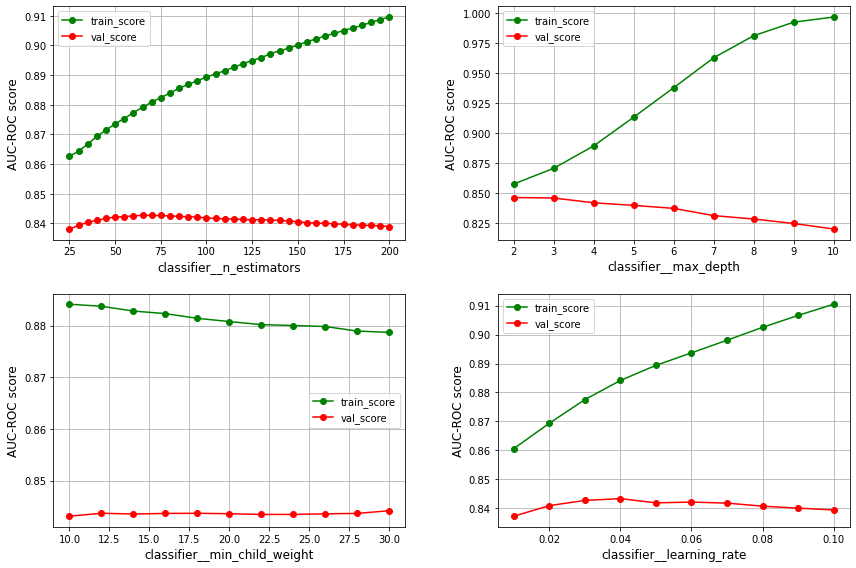

In [44]:
%%time
plot_validation_curves(xgb_estimator,
                       classifier__n_estimators = np.arange(25, 201, 5, dtype=int),
                       classifier__max_depth = np.arange(2, 11, dtype=int),
                       classifier__min_child_weight = np.arange(10, 31, 2),
                       classifier__learning_rate = np.arange(0.01, 0.11, 0.01))

In [47]:
%%time
xgb_estimator.set_params(classifier__n_estimators = 60, classifier__max_depth = 2,
                        classifier__min_child_weight = 30, classifier__learning_rate = 0.02)
xgb_parameters_grid = {
    'classifier__max_depth': np.arange(2, 6, dtype=int),
    'classifier__n_estimators': np.arange(50, 201, 25, dtype=int),
    'classifier__min_child_weight': np.arange(20, 41, 10),
    'classifier__learning_rate': np.arange(0.01, 0.051, 0.01)
}   

xgb_grid_cv = model_selection.RandomizedSearchCV(xgb_estimator, xgb_parameters_grid, n_iter=300,
                                                 scoring='roc_auc', cv=cv_split, n_jobs=-1)
xgb_grid_cv.fit(train_data, train_labels)

print(f'Best score is {xgb_grid_cv.best_score_} with the following parameters:\n{xgb_grid_cv.best_params_}')

Best score is 0.8478866611879663 with the following parameters:
{'classifier__n_estimators': 200, 'classifier__min_child_weight': 20, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.04}
CPU times: user 17.6 s, sys: 761 ms, total: 18.3 s
Wall time: 11min 19s


In [48]:
xgb_estimator.set_params(classifier__n_estimators = 200, classifier__max_depth = 2,
                        classifier__min_child_weight = 20, classifier__learning_rate = 0.04)

cross_val_results('xgb_bsln + grid_search', xgb_estimator)
clf_results

Metrics on all folds:
test_roc_auc: [0.85932795 0.82695865 0.86434905 0.84091099]
test_accuracy: [0.76233865 0.73348519 0.75094913 0.73196659]
test_precision: [0.52862595 0.49261993 0.51369863 0.49183303]
test_recall: [0.80758017 0.77842566 0.87209302 0.7877907 ]
test_f1: [0.63898501 0.60338983 0.64655172 0.60558659]
test_average_precision: [0.66444178 0.62341601 0.68564465 0.66498157]


,test_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_average_precision
log_bsln,0.843631,0.742217,0.503681,0.806370,0.619873,0.648374
log_bsln + grid_search,0.844282,0.741458,0.502703,0.807101,0.619356,0.649632
rnd_bsln,0.839807,0.781131,0.565161,0.695738,0.623501,0.644039
rnd_bsln + grid_search,0.845398,0.749620,0.513210,0.786731,0.620965,0.653043
xgb_bsln,0.841832,0.745824,0.508026,0.794728,0.619629,0.652336
xgb_bsln + grid_search,0.847887,0.744685,0.506694,0.811472,0.623628,0.659621


In [49]:
final_score('xgb', xgb_estimator)

XGBoost predictions on kaggle-test: $AUC - ROC = 0.85047$.

### 5.2 Catboost <a name = "catb"></a>
Catboost is really good library, but combining it with scikit-learn pipelines is a stumbling block for me. Well, I have to use its implemented classes like as Catboost.Pool, Catboost.cv and so on.

In [50]:
cat_clf = catb.CatBoostClassifier(iterations=1500, learning_rate=0.01, depth=4, loss_function='Logloss', 
                                  early_stopping_rounds = 50, eval_metric='AUC:hints=skip_train~false', 
                                  auto_class_weights='Balanced', boosting_type='Ordered', random_state=42, logging_level='Silent')

cat_train_data = catb.Pool(data=train_data.drop(columns='HasPhoneService'), label=train_labels, cat_features=cat_feats)

In [51]:
%%time
cat_cv = catb.cv(pool=cat_train_data, params=cat_clf.get_params(), folds=cv_split)

CPU times: user 1min 36s, sys: 11.4 s, total: 1min 48s
Wall time: 3min


In [52]:
cat_cv.iloc[[cat_cv['test-AUC-mean'].idxmax()]]

,iterations,test-AUC-mean,test-AUC-std,train-AUC-mean,train-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
1099,1099,0.846397,0.01672,0.858262,0.004157,0.484908,0.023678,0.467096,0.006232


In [53]:
%%time
cat_grid = {'learning_rate': np.arange(0.01, 0.051, 0.01),
           'depth': np.arange(2, 7),
            'l2_leaf_reg': [2.5, 3.0, 3.5],
            'auto_class_weights': ['SqrtBalanced', 'Balanced']}
cat_grid_results = cat_clf.randomized_search(cat_grid, cat_train_data, n_iter=50, 
                                             cv=cv_split, search_by_train_test_split=False)

0:	loss: 0.8462860	best: 0.8462860 (0)	total: 2m 56s	remaining: 2h 23m 53s
1:	loss: 0.8461037	best: 0.8462860 (0)	total: 4m 41s	remaining: 1h 52m 25s
2:	loss: 0.8461851	best: 0.8462860 (0)	total: 7m 44s	remaining: 2h 1m 24s
3:	loss: 0.8463405	best: 0.8463405 (3)	total: 9m 43s	remaining: 1h 51m 47s
4:	loss: 0.8460137	best: 0.8463405 (3)	total: 10m 49s	remaining: 1h 37m 25s
5:	loss: 0.8462860	best: 0.8463405 (3)	total: 13m 41s	remaining: 1h 40m 26s
6:	loss: 0.8459911	best: 0.8463405 (3)	total: 15m 15s	remaining: 1h 33m 46s
7:	loss: 0.8464321	best: 0.8464321 (7)	total: 16m 33s	remaining: 1h 26m 53s
8:	loss: 0.8465552	best: 0.8465552 (8)	total: 17m 25s	remaining: 1h 19m 24s
9:	loss: 0.8463405	best: 0.8465552 (8)	total: 19m 14s	remaining: 1h 16m 57s
10:	loss: 0.8465005	best: 0.8465552 (8)	total: 20m 23s	remaining: 1h 12m 19s
11:	loss: 0.8464781	best: 0.8465552 (8)	total: 22m 9s	remaining: 1h 10m 11s
12:	loss: 0.8465094	best: 0.8465552 (8)	total: 23m 10s	remaining: 1h 5m 57s
13:	loss: 0.8468

In [54]:
cat_grid_results['params']

{'auto_class_weights': 'SqrtBalanced',
 'depth': 4,
 'l2_leaf_reg': 2.5,
 'learning_rate': 0.04}

In [56]:
cat_test_data = catb.Pool(data=test_data.drop(columns='HasPhoneService'), cat_features=cat_feats)
submission = pd.read_csv('./submission.csv')
submission['Churn'] = cat_clf.predict_proba(cat_test_data)[:, 1]
submission.to_csv('cat_answers.csv', index = False)

CatBoost predictions on kaggle-test: $AUC - ROC = 0.85185$, still pretty close to cross-validation results.